results and win-probability graphs below

## In-match Predictions



The following methods will be tested primarily on tour-level matches for which we have point-by-point data. The matches span 2010-2017, accounting for nearly half of all tour-level matches within this time. Point-by-point records in Sackmann's dataset take the form of the following string:

(Mikhail Youzhny vs. Evgeny Donskoy Australian Open 2013)

P=``SSRSS;RRRR;SRSSS;SRRSRSSS;SRSSRS;RSRSSS;SRSRSS;RSRSRSSS;SSSS.SSSRRRSS;

RSSSS;SSRSS;SSSRS;SSSS;RRRSSSSRRSSRRSRSSS;SRSRSS;SSSRS;RSRSSRSS;SSSS;SRSSS;

RSRSSRRSSS;R/SR/SS/RR/RS/SR.RSRRR;...''

S denotes a point won by the server and R a point won by the returner. Individual games are separated by ";" sets by "." and service changes in tiebreaks by "/". By iterating through the string, one can construct n data points $\{P_0,P_1,...,P_{n-1}\}$ from a match with n total points, with $P_i$ representing the subset of the match after $i$ points have been played. W

P_0 = ""

P_1 = "S"

P_1 = "SS"

P_2 = "SSR"

...

With $M = \{M_1,M_2,...M_k\}$ complete match-strings in our point-by-point data set, the size of our enumerated data set then becomes $\sum_{i=1}^k |M_i|$. This comes out to 1,231,122 points for ATP matches.


As a baseline, we first consider a logistic regression model. 

From any scoreline  ($s_i,s_j,g_i,g_j,{x}_i,{x}_j$), we can simply feed these parameters into our model. Logistic Regression's structure makes it easy to consider additional features for each player, such as elo difference, surface elo difference, etc. Before adding all features to the model, we consider two baselines: a model using ($s_i,s_j,g_i,g_j,{x}_i,{x}_j$) and another model trained on elo differences and a lead heuristic $L_{ij}$.

This heuristic simply calculates one player's total lead in sets, games, and points:

$L_{ij} = s_i-s_j + \frac{1}{6}(g_i-g_j) + \frac{1}{24}(x_i-x_j)$

The coefficients preserve order between sets, games, and points, as one cannot lead by six games without winning a set or four points without winning a game.

Cross Validation

Each match in our best-of-three dataset has around 160 points on average. We implement five-fold group validation, keeping matches together, so points from the same match do not overlap between train, validation, and test sets. This prevents a single match from informing the model before its later assessed by the model.



1) lead-margin + elo diff + surface elo diff 

2) sets + games + points

3) all features

With all features, our model performs best, with 76.59% accuracy and .4805 cross entropy. This means that, at a glance, we can correctly classify 76.59% percent of data points as belonging to a "won" or "lost" match. When computing the likelihood of our predictions, .4805 is the average negative log-likelihood of our entire dataset. While this is less interpretable, we may use it as a bench mark to compare with other models. The ultimate goal of this project is to minimize cross entropy. Given the volatile nature of sports, minimizing cross entropy can be very difficult. Results and two sample win-probability graphs are listed below.

In [5]:
import numpy as np
import math
import time
import pandas as pd
from helper_functions import cross_validate
from sklearn import linear_model, ensemble
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

df_pred = pd.read_csv('my_data/feature_df_pbp3_9_6_alphas.csv')

In [3]:
scores = ['sets_0','sets_1','games_0','games_1','points_0','points_1']
break_feats = [u'up_break_point', u'down_break_point', u'break_adv']
point_rates = [u'sv_points_pct_0', u'sv_points_pct_1']
cols = ['in_lead','elo_diff','s_elo_diff']+scores+break_feats+point_rates
c = int(max(df_pred['match_id'])*.8)
val_df,test_df = df_pred[df_pred['match_id']<=c],df_pred[df_pred['match_id']>c]

In [6]:
# for MLP, I would consider grid search over alpha, batch_size, and hidden_layer_sizes...
models = [linear_model.LogisticRegression(fit_intercept = True)]
model_hparams = {'LogisticRegression':{'C':[100]}}
baseline = ['lead_margin','elo_diff','s_elo_diff']
column_lists = [baseline,scores,baseline+scores,cols]

for columns in column_lists:
    print 'cols: ',columns
    Xtrain, ytrain = val_df[columns],val_df['winner']
    Xtest, ytest = test_df[columns],test_df['winner']
    for clf in models:
        model_name = clf.__str__().split('(')[0]
        print model_name
        best_hyper_p = cross_validate(val_df,clf,columns,'winner',model_hparams[model_name],n_splits=5)
        for key in best_hyper_p.keys():
            setattr(clf,key,best_hyper_p[key])
        clf.fit(Xtrain,ytrain)

        probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
        train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
        train_accuracy = clf.score(Xtrain, ytrain)
        test_accuracy = clf.score(Xtest, ytest)  
        print train_loss, test_loss
        print train_accuracy, test_accuracy
    print '\n'

cols:  ['lead_margin', 'elo_diff', 's_elo_diff']
LogisticRegression
searching for hyperparams...
100 :  0.755858623808
best:  {'C': 100}
0.497489279481 0.49802837817
0.756833122546 0.756269658758


cols:  ['sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1']
LogisticRegression
searching for hyperparams...
100 :  0.71871858842
best:  {'C': 100}
0.53446061423 0.531025075295
0.72066689526 0.726680332986


cols:  ['lead_margin', 'elo_diff', 's_elo_diff', 'sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1']
LogisticRegression
searching for hyperparams...
100 :  0.763644243487
best:  {'C': 100}
0.482247493213 0.482366641109
0.764513040497 0.764630546237


cols:  ['in_lead', 'elo_diff', 's_elo_diff', 'sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1', u'up_break_point', u'down_break_point', u'break_adv', u'sv_points_pct_0', u'sv_points_pct_1']
LogisticRegression
searching for hyperparams...
100 :  0.765050700148
best:  {'C': 100}
0.480570570659 0.480527

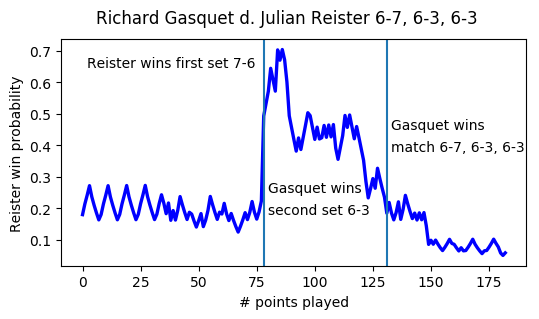

In [36]:
# graphically, try to compare different probabilities of different models
import matplotlib.pyplot as plt
%matplotlib inline

probs = np.concatenate((probs_train[:,1],probs_test[:,1]))
df_pred['prob4'] = probs

match1 = df_pred[df_pred['match_id']==1]
m1_probs = match1['prob4']
set_lengths = [len(a) for a in list(match1['score'])[-1].replace(';','').replace('/','').split('.')]
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),m1_probs,'b-',linewidth=2.4)
fig.suptitle('Richard Gasquet d. Julian Reister 6-7, 6-3, 6-3')
ax.set_ylabel('Reister win probability')
ax.set_xlabel('# points played')
ax.text(2, 0.65, r'Reister wins first set 7-6')
ax.text(80, 0.25, r'Gasquet wins')
ax.text(80, 0.18, r'second set 6-3')
ax.text(133, 0.45, r'Gasquet wins')
ax.text(133, 0.38, r'match 6-7, 6-3, 6-3')
ax.axvline(set_lengths[0]); ax.axvline(sum(set_lengths[:2]))
plt.savefig('gasquet_reister_9_6_all_features')
fig.show()

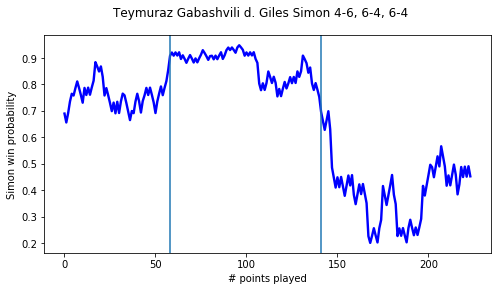

In [57]:
probs = np.concatenate((probs_train[:,1],probs_test[:,1]))
df_pred['prob4'] = probs

match1 = df_pred[df_pred['match_id']==6310]
m1_probs = match1['prob4']
set_lengths = [len(a) for a in list(match1['score'])[-1].replace(';','').replace('/','').split('.')]
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),m1_probs,'b-',linewidth=2.4)
fig.suptitle('Teymuraz Gabashvili d. Giles Simon 4-6, 6-4, 6-4')
ax.set_ylabel('Simon win probability')
ax.set_xlabel('# points played')
ax.axvline(set_lengths[0]); ax.axvline(sum(set_lengths[:2]))
plt.savefig('simon_gabashvili_9_6_all_features')
fig.show()